# Intelligent Systems for Pattern Recognition (unipi)
## Assigment 1 - 3rd choice

>Perform image segmentation on one of the eight image thematic subsets. Note that each file has a name starting with a number from 1 to 8, which indicates the thematic subset, followed by the rest of the file name. I suggest to use image subsets “1_*” or “2_*”.  Use the normalized cut algorithm to perform image segmentation. You are welcome to confront the result with kmeans segmentation algorithm if you wish.

[Used dataset](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip) (from microsoft)

---
## Load dataset

In [1]:
import os
import cv2 # use OpenCV for dealing with images
from sklearn.cluster import KMeans
import numpy as np

In [2]:
dataset_dir = 'MSRC_ObjCategImageDatabase_v1'
image_subset_prefix = "1_"
images = {}
#import image subset by listing all images in dataset directory
for filename in os.listdir(dataset_dir):
    if filename.startswith(image_subset_prefix):
        images[filename] = cv2.imread(dataset_dir+os.sep+filename, cv2.IMREAD_COLOR)
        
# obtain dict filename-image matrix
print([v.shape for k, v in images.items() ])

[(213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3), (213, 320, 3)]


___
## K-MEANS approach
### Let's first try the easiest approach to image segmentation by applying k-means clustering algorithm to pixel colors

In [3]:
# let's organize data in a matrix containing (#pixel - RGB value)
imageRGB_matrix = {}
for k, v in images.items():
    npixels = v.shape[0] * v.shape[1]
    matrix = np.transpose(v)
    matrix = matrix.reshape(npixels, 3)
    imageRGB_matrix[k] = matrix
print(matrix.shape)

68160

`Choose best k by looking at sum of squared distances`

In [11]:
bestk = KMeans(n_clusters=5, n_init=10, verbose=0, n_jobs=-1).fit(imageRGB_matrix['1_11_s.bmp'])

# for k in range(3, 20):
#     kmeans = KMeans(n_clusters=k, n_init=10, n_jobs=-1).fit(imageRGB_matrix['1_11_s.bmp'])
#     if kmeans.inertia_ < bestk.inertia_:
#         bestk = kmeans

In [12]:
image_to_print = bestk.cluster_centers_[bestk.labels_[0]]
for i, l in enumerate(bestk.labels_):
    if i != 0:
        image_to_print = np.vstack((image_to_print, bestk.cluster_centers_[l]))
print(image_to_print.shape)        
# convert image back to 3d tensor
image_to_print = np.transpose(image_to_print)
print(image_to_print.shape)
image_to_print = image_to_print.reshape(213, 320, 3)
image_to_print
#cv2.imshow('image',image_to_print)

(68160, 3)
(3, 68160)


array([[[230.8001128 , 230.8001128 , 230.8001128 ],
        [230.8001128 , 230.8001128 , 230.8001128 ],
        [230.8001128 , 230.8001128 , 230.8001128 ],
        ...,
        [ 65.52665245,  65.52665245,  25.59725658],
        [ 65.52665245,  65.52665245,  65.52665245],
        [ 65.52665245,  65.52665245,  65.52665245]],

       [[ 65.52665245,  65.52665245,  65.52665245],
        [ 65.52665245,  65.52665245,  25.59725658],
        [ 65.52665245,  65.52665245,  65.52665245],
        ...,
        [ 65.52665245,  25.59725658,  65.52665245],
        [ 65.52665245,  25.59725658,  65.52665245],
        [230.8001128 , 230.8001128 , 230.8001128 ]],

       [[230.8001128 , 230.8001128 , 230.8001128 ],
        [230.8001128 , 230.8001128 , 230.8001128 ],
        [230.8001128 , 230.8001128 , 230.8001128 ],
        ...,
        [ 65.52665245,  65.52665245,  65.52665245],
        [ 65.52665245,  25.59725658,  25.59725658],
        [ 25.59725658,  25.59725658,  25.59725658]],

       ...,

      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


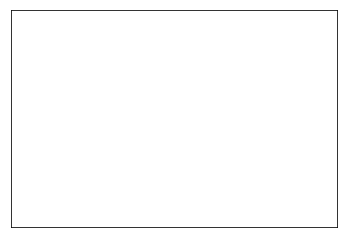

In [13]:
bestk.labels_.shape
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

plt.imshow(image_to_print)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
